In [4]:
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#Spiltting the data
from sklearn.model_selection import train_test_split

#token Vectoriser and encoding categorical variable
import nltk
import string
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

#Sampling Technique
from imblearn.over_sampling import SMOTE

#pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

#modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#reports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Now that I have evaluated the Logistic regression, Random forest and XG boost models for imbalanced dataset, I will over sample the dataset using SMOTE technique and will rerun the above mentioned models with the over sampled dataset to evaluate the model performance against the base model.

Let us load the cleaned dataset from the `EDA` python script file.

In [96]:
#Loading the data
df = pd.read_csv('Data/fake_job_posting_clean.csv')
df.head()

,Unnamed: 0,country,has_company_logo,employment_type,required_experience,required_education,function,fraudulent,text
0,0,US,1,Other,Internship,Unspecified,Marketing,0,"Marketing Intern We're Food52, and we've creat..."
1,1,NZ,1,Full-time,Not Applicable,Unspecified,Customer Service,0,Customer Service - Cloud Video Production 90 S...
2,2,US,1,Other,Not Applicable,Unspecified,Other,0,Commissioning Machinery Assistant (CMA) Valor ...
3,3,US,1,Full-time,Mid-Senior level,Bachelor's Degree,Sales,0,Account Executive - Washington DC Our passion ...
4,4,US,1,Full-time,Mid-Senior level,Bachelor's Degree,Health Care Provider,0,Bill Review Manager SpotSource Solutions LLC i...


We can see that the index column is duplicated in the new data file.\
Let us drop the 'Unnamed: 0' column from our dataset. 

In [97]:
##Removing the index column
df.drop('Unnamed: 0', axis=1, inplace = True)

In [98]:
df.head()

,country,has_company_logo,employment_type,required_experience,required_education,function,fraudulent,text
0,US,1,Other,Internship,Unspecified,Marketing,0,"Marketing Intern We're Food52, and we've creat..."
1,NZ,1,Full-time,Not Applicable,Unspecified,Customer Service,0,Customer Service - Cloud Video Production 90 S...
2,US,1,Other,Not Applicable,Unspecified,Other,0,Commissioning Machinery Assistant (CMA) Valor ...
3,US,1,Full-time,Mid-Senior level,Bachelor's Degree,Sales,0,Account Executive - Washington DC Our passion ...
4,US,1,Full-time,Mid-Senior level,Bachelor's Degree,Health Care Provider,0,Bill Review Manager SpotSource Solutions LLC i...


Let us now split the dataset into training and test dataset before we perform any data preprocessing in our dataset.

In [11]:
## Train Test Split of data
X = df.drop('fraudulent', axis =1)
y = df['fraudulent']

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.20, stratify = y, random_state = 1)

As we did in the imbalanced dataset, we will define the tokeniser function where we will remove punctuations, stop words and split each word by space.

In [12]:
#Defining the tokeniser function
nltk.download('stopwords')
stemmer = nltk.stem.PorterStemmer()

from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    
    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
        
    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaiganeshkannan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Preprocessing ###
I used the tokenizer defined above in TF-IDF vectoriser to convert the text column in to vectorised token.

Also for the categorical features `Country`, `employment_type`, `required_education`, `required_experience` and `function` I have used one hot encoder to encode.

**Column Transformation:**\
I will now pass the TF-IDF vetorizer and Onehotencoder into 'ColumnTransformer( )' function to transform the text and the categorical column in our dataset.

**Over Sampling:**\
For over sampling I have used SMOTE( ) from imblearn package. I have set the `sampling_strategy` to 0.3 as I would just like to over sample my data just for 30% and not 50%.

**Pipeline:**\
I have used `imblearn.pipeline` for these oversampled data as `SMOTE( )` technique can't be implemented in the `sklearn.pipeline`.

In the pipeline I have passed the column transformer first, followed by the SMOTE function finally the model.

### Modelling ###
**Logistic Regression:**\
We will now store the hyper parameter values to be tunned in a list as a dictionary. These parameter will be passed in the grid search for hyper parameter tunning.

For logistic regression I have used C value and penalty as my hyperparameter and have tunned it with few values using grid search.

In [33]:
#set up column transformer parameters
col_transform = [('OHE_transform', OneHotEncoder(handle_unknown = 'ignore'), ['country',
                                                                              'employment_type',
                                                                              'required_education',
                                                                              'required_experience',
                                                                              'function']),
                ('text_transform', 
                 TfidfVectorizer(min_df=20, tokenizer=my_tokenizer, ngram_range = (1,3)), 
                 'text')]

#Setting up the pipeline for execution
pipeline_estimators = [('col_trans', ColumnTransformer(col_transform)),
                       ('sampling', SMOTE(sampling_strategy = 0.3, random_state = 1)),
                      ('model', LogisticRegression())]

pipe = Pipeline(pipeline_estimators)

## Defining the hyperparameter values for grid search
param_grid = [
    {'model': [LogisticRegression(solver='liblinear')],
    'model__C': [0.001,0.01,0.1, 0.3,0.5],
    'model__penalty': ['l1','l2']}]

# Setting up the grid search
grid_smote = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)

We will now fit the training dataset to the instantiated grid search function

In [34]:
# Fitting the model on train dataset
fitted_grid_s = grid_smote.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 39.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 45.4min finished
/Users/jaiganeshkannan/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


We can call the `.best_estimator_` parameter to see the best paramaters for the logistic regression model.

In [89]:
#Finding the hyperparameters of the best model after gird search
fitted_grid_s.best_estimator_

Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('OHE_transform',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['country', 'employment_type',
                                                   'required_education',
                                                   'required_experience',
                                                 

We can see from the above results that, the grid search has determined that the model with a `C value` of 0.5 and the `penalty` factor of l2 has the best results. Let us now score our test data on our fitted model

In [90]:
#Printing the test and train accuracy score
print(fitted_grid_s.score(X_test, y_test))
print(fitted_grid_s.score(X_train, y_train))

0.9809659090909091
0.987072945521699


I would like to store the predictions made by the best model using `.predict` function and will check for the confusion matrix to see how many datapoints are misclassified (especially for fraudulent jobs)

In [38]:
#Storing the prediction for the test dataset
y_pred_sm = fitted_grid_s.predict(X_test)

#Confusion matrix for test set
confusion_matrix(y_test, y_pred_sm)

array([[3315,   34],
       [  33,  138]])

In [39]:
##### Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_sm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3349
           1       0.80      0.81      0.80       171

    accuracy                           0.98      3520
   macro avg       0.90      0.90      0.90      3520
weighted avg       0.98      0.98      0.98      3520



Using the `classification report` from sklearn package we have got the recall and precision for the fraudulent jobs. 

We can see that the model was able to improve the recall percentage from 0.35 to 0.81 after SMOTE( ). I would also like to check for the ROC curve to see how confident is the model about its predictions

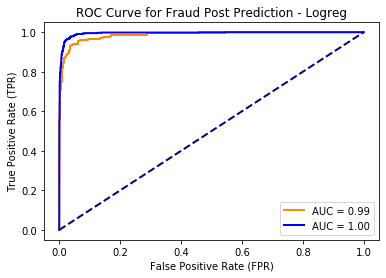

Test AUC score:0.9855346537938355
Train AUC score:0.9954524795392642



In [40]:
# Regenerate scores
y_proba_logreg_test = fitted_grid_s.predict_proba(X_test)[:,1]
y_proba_logreg_train = fitted_grid_s.predict_proba(X_train)[:,1]

from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, y_proba_logreg_test)
roc_auc_logreg_test = roc_auc_score(y_test, y_proba_logreg_test)

fprs_train, tprs_train, thresholds_train = roc_curve(y_train, y_proba_logreg_train)
roc_auc_logreg_train = roc_auc_score(y_train, y_proba_logreg_train)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc_logreg_test)
plt.plot(fprs_train, tprs_train, color='blue',
         lw=2, label='AUC = %0.2f' % roc_auc_logreg_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Fraud Post Prediction - Logreg')
plt.legend(loc="best")
plt.show()

print(f'Test AUC score:{roc_auc_logreg_test}')
print(f'Train AUC score:{roc_auc_logreg_train}')
print()

We have AUC score of 0.985 and 0.995 for test and train dataset respectively. Hence we can say that my model is very confident about its predictions.

Let me now apply the same pipeline for Randomforest and XG Boost model, and check for the model performance metrics.

For random forest model I have used the `n_estimators` and `max_depth` as my hyper-paramter for tunning.

In [92]:
#set up column transformer parameters
col_transform = [('OHE_transform', OneHotEncoder(handle_unknown = 'ignore'), ['country',
                                                                              'employment_type',
                                                                              'required_education',
                                                                              'required_experience',
                                                                              'function']),
                ('text_transform', 
                 TfidfVectorizer(min_df=20, tokenizer=my_tokenizer, ngram_range = (1,3)), 
                 'text')]

pipeline_estimators = [('col_trans', ColumnTransformer(col_transform)),
                       ('sampling', SMOTE(sampling_strategy = 0.3, random_state = 1)),
                      ('model', RandomForestClassifier())]

pipe = Pipeline(pipeline_estimators)

param_grid = [
    {'model': [RandomForestClassifier()],
    'model__n_estimators': [10,20,50,100],
    'model__max_depth': [10,50,100,500,1000]}]

grid_smote_rf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)

Let us fit the model for the train data.

In [42]:
fitted_grid_s_rf = grid_smote_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 88.2min finished
/Users/jaiganeshkannan/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Let us check the hyper parameter values for the best random forest model after grid search cross validation.

In [43]:
fitted_grid_s_rf.best_estimator_

Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('OHE_transform',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['country', 'employment_type',
                                                   'required_education',
                                                   'required_experience',
                                                 

The random forest model was have its best result with the `n_estimators = 100` and `max_depth=1000`. Let us now score the fitted model on the test dataset.

In [44]:
print(fitted_grid_s_rf.score(X_test, y_test))
print(fitted_grid_s_rf.score(X_train, y_train))

0.9840909090909091
1.0


We have a test accuracy of 0.984 and a perfect train accuracy of 1.0. We will now look into the classification report for other model performance metrics.

In [45]:
y_pred_sm_rf = fitted_grid_s_rf.predict(X_test)

#Confusion matrix for test set
confusion_matrix(y_test, y_pred_sm_rf)

array([[3348,    1],
       [  55,  116]])

In [46]:
##Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_sm_rf))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3349
           1       0.99      0.68      0.81       171

    accuracy                           0.98      3520
   macro avg       0.99      0.84      0.90      3520
weighted avg       0.98      0.98      0.98      3520



From the `classification report` we can see that random forest model with SMOTE( ) has a recall percentage of 0.68 which is lower than our logistic regression model. But the precision is higher in Random forest model when compared to logistic regression.

Let us look in to the ROC curve for random forest model.

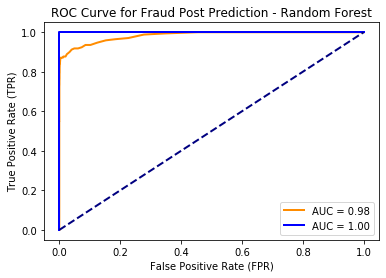

Test AUC score:0.9832750982662188
Train AUC score:0.9999999999999999



In [80]:
# Regenerate scores
y_proba_rf_test = fitted_grid_s_rf.predict_proba(X_test)[:,1]
y_proba_rf_train = fitted_grid_s_rf.predict_proba(X_train)[:,1]

from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, y_proba_rf_test)
roc_auc_rf_test = roc_auc_score(y_test, y_proba_rf_test)

fprs_train, tprs_train, thresholds_train = roc_curve(y_train, y_proba_rf_train)
roc_auc_rf_train = roc_auc_score(y_train, y_proba_rf_train)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc_rf_test)
plt.plot(fprs_train, tprs_train, color='blue',
         lw=2, label='AUC = %0.2f' % roc_auc_rf_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Fraud Post Prediction - Random Forest')
plt.legend(loc="best")
plt.show()

print(f'Test AUC score:{roc_auc_rf_test}')
print(f'Train AUC score:{roc_auc_rf_train}')
print()

The model looks very confident with the AUC score of 0.983 and 0.999 for test and train dataset respectively.

We will now run the model with XG boost and will check for the model performance. I have used `learning_rate`, `max_depth` and `n_estimator` as my hyperparameter for tuning.

In [50]:
#set up column transformer parameters

col_transform = [('OHE_transform', OneHotEncoder(handle_unknown = 'ignore'), ['country',
                                                                              'employment_type',
                                                                              'required_education',
                                                                              'required_experience',
                                                                              'function']),
                ('text_transform', 
                 TfidfVectorizer(min_df=20, tokenizer=my_tokenizer, ngram_range = (1,3)), 
                 'text')]

pipeline_estimators = [('col_trans', ColumnTransformer(col_transform)),
                       ('sampling', SMOTE(sampling_strategy = 0.3, random_state = 1)),
                      ('model', XGBClassifier())]

pipe = Pipeline(pipeline_estimators)

param_grid = [
    {'model': [XGBClassifier()],
    'model__learning_rate': [0.001,0.01,0.1,0.3,0.5],
    'model__max_depth': [10,50,100,500,1000],
    'model__n_estimators': [10,30,50,100]}]


grid_s_XGB = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)

Let's fit the model for our trian dataset. Then we will check the hyper parameter values for the best XG boost model.

In [73]:
fitted_grid_s_XGB = grid_s_XGB.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/jaiganeshkannan/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 90.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 476.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 892.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 1131.2min finished
/Users/jaiganeshkannan/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [74]:
fitted_grid_s_XGB.best_estimator_

Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('OHE_transform',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['country', 'employment_type',
                                                   'required_education',
                                                   'required_experience',
                                                 

Our best model for XG boost has the `learning_rate = 0.1`, `n_estimators = 100` and `max_depth=50`. Let us now score the test dataset on the fitted model.

In [75]:
print(fitted_grid_s_XGB.score(X_test, y_test))
print(fitted_grid_s_XGB.score(X_train, y_train))

0.9877840909090909
1.0


We have a test accuracy of 0.988 and a perfect train accuracy of 1.0. We will now look into the classification report for other model performance metrics.

In [76]:
y_pred_sm_XGB = fitted_grid_s_XGB.predict(X_test)

#Confusion matrix for test set
confusion_matrix(y_test, y_pred_sm_XGB)

array([[3342,    7],
       [  36,  135]])

In [77]:
##Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_sm_XGB))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3349
           1       0.95      0.79      0.86       171

    accuracy                           0.99      3520
   macro avg       0.97      0.89      0.93      3520
weighted avg       0.99      0.99      0.99      3520



From the `classification report` we can see that XG Boost model with SMOTE( ) has a recall percentage of 0.79 which is slightly lower than our logistic regression model, but the precision is mush higher than the logistic regression.

Let us look in to the ROC curve for XG Boost model.

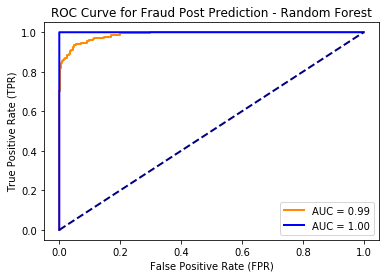

Test AUC score:0.9878623102994871
Train AUC score:1.0



In [81]:
# Regenerate scores
y_proba_XGB_test = fitted_grid_s_XGB.predict_proba(X_test)[:,1]
y_proba_XGB_train = fitted_grid_s_XGB.predict_proba(X_train)[:,1]

from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, y_proba_XGB_test)
roc_auc_XGB_test = roc_auc_score(y_test, y_proba_XGB_test)

fprs_train, tprs_train, thresholds_train = roc_curve(y_train, y_proba_XGB_train)
roc_auc_XGB_train = roc_auc_score(y_train, y_proba_XGB_train)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc_XGB_test)
plt.plot(fprs_train, tprs_train, color='blue',
         lw=2, label='AUC = %0.2f' % roc_auc_XGB_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Fraud Post Prediction - Random Forest')
plt.legend(loc="best")
plt.show()

print(f'Test AUC score:{roc_auc_XGB_test}')
print(f'Train AUC score:{roc_auc_XGB_train}')
print()

The model looks very confident with the AUC score of 0.987 and 1.0 for test and train dataset respectively.

Based on the model performance, we can see that logistic reression (0.81) has the highest recall percentage followed by XG boost (0.79) but the precision is higher is XG boost (0.95) when compared to the logistic regession (0.80).

For this problem statement, I choose logistic regression model with SMOTE as it has the highest recall percentage. Though the precision is low when compared to XG boost, I feel that the cost of sharing the personal information on a fraudulent job post is much higher when compared to the cost of not applying to a real job. Please look for the model diagnostics in the `logreg_smote.ipynb` python file.